In [4]:
import glob,os
import sys
import numpy as np
import cv2
from skimage.color import rgb2yuv,rgb2ycbcr
from local_mmt import matchTemplates,drawBoxesOnRGB
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [5]:
def get_boxes(path):
    image_rg = cv2.imread(path)
    image_rgb = cv2.cvtColor(image_rg, cv2.COLOR_BGR2RGB)

    image_t = cv2.imread('templete_pt4.png')
    templete = image_t#[1450:1600,2250:2390]
    
    templete_rgb = cv2.cvtColor(templete, cv2.COLOR_BGR2RGB)
    listTemplate = [('temp', templete_rgb)]
    tubes = matchTemplates(listTemplate, image_rgb, N_object=8,score_threshold=0.2, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.0)
    print(tubes)
    Overlay = drawBoxesOnRGB(image_rgb, tubes, boxThickness=5)
    plt.figure(figsize = (10,10))
    # plt.axis("off")
    plt.imshow(Overlay)
    return sorted(tubes)

In [6]:
def get_dir(directory):
    img_path = []
    img_names = []
    for path,subdirs,files in os.walk(directory):

        for name in files:
            if name.endswith('.png'):
                img_path.append(os.path.join(path,name))
                img_names.append(name.rsplit('.',-1)[0])
    return sorted(img_path),sorted(img_names)


In [7]:
red_paths,red_names = get_dir('Final_data/full_tubes/journal_data/red/')

In [8]:
red_labels = np.zeros((len(red_paths)))

In [9]:
print(red_labels.shape)

(4170,)


In [10]:
yel_paths,yel_names = get_dir('Final_data/full_tubes/journal_data/yellow/')
yel_labels = np.ones((len(yel_paths)))

In [11]:


# t_paths = np.concatenate((red_paths[:99], yel_paths[:99]))
# t_labels = np.concatenate((red_labels[:99], yel_labels[:99]))

labels = np.concatenate((red_labels, yel_labels))
paths = np.concatenate((red_paths, yel_paths))

data= np.vstack((paths,labels)).T
# t_data= np.vstack((t_paths,t_labels)).T
print(data)

[['Final_data/full_tubes/journal_data/red/t_1593636962crop_0.png' '0.0']
 ['Final_data/full_tubes/journal_data/red/t_1593636962crop_1.png' '0.0']
 ['Final_data/full_tubes/journal_data/red/t_1593636962crop_2.png' '0.0']
 ...
 ['Final_data/full_tubes/journal_data/yellow/t_1596728761crop_7.png'
  '1.0']
 ['Final_data/full_tubes/journal_data/yellow/t_1596728784crop_7.png'
  '1.0']
 ['Final_data/full_tubes/journal_data/yellow/t_1596728830crop_7.png'
  '1.0']]


In [12]:
np.random.seed(0)
np.random.shuffle(data)
# print(data)

split = 0.9 * len(data)

train = data[:int(split)]
test = data[int(split):]
uniqueValues, occurCount = np.unique(test[:,1], return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  ['0.0' '1.0']
Occurrence Count :  [420  63]


In [13]:
print(len(test))

483


In [14]:
def my_datagen(data,batch_size):
    
    
    labels = []
    imgs = []
    
    datagen= ImageDataGenerator(
                                brightness_range=[0.7, 1.2],
                                fill_mode='nearest',    
                                horizontal_flip=True,
                                data_format='channels_last',
                                width_shift_range=[-20,20],
                                height_shift_range=[-20,20]
                                
                               )
    
    while True:
        for i in range(len(data)):
            img = cv2.imread(data[i,0])
#             print(data[i,0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = datagen.random_transform(img)
            imgs.append(img)
            labels.append(data[i,1])

            if ((i+1)%batch_size==0):
                yield (np.asarray(imgs),np.asarray(labels))
                labels = []
                imgs = []


        yield (np.asarray(imgs),np.asarray(labels))

In [15]:
import keras
from keras.utils import plot_model
from keras.models import Model,load_model
from keras.layers import Input
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D


In [16]:
visible = Input(shape=(375,260,3))
conv1 = Conv2D(32, kernel_size=5, activation='relu',padding='valid')(visible)
conv1_1 = Conv2D(64, kernel_size=5, activation='relu',padding='valid')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
conv2 = Conv2D(16, kernel_size=5, activation='relu',padding='valid')(pool1)
conv2_2 = Conv2D(8, kernel_size=5, activation='relu',padding='valid')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
flat = Flatten()(pool2)
hidden1 = Dense(946, activation='relu')(flat)
hidden2 = Dense(200, activation='relu')(hidden1)
hidden3 = Dense(100, activation='relu')(hidden2)
output = Dense(1, activation='sigmoid')(hidden3)
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())
# plot graph
# plot_model(model, to_file='convolutional_neural_network.png')
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 375, 260, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 371, 256, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 367, 252, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 183, 126, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 179, 122, 16)      25616     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 175, 118, 8)       3208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 87, 59, 8)         0   

In [28]:
## Check if the generator is working fine

In [17]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

batch_size = 10
steps = int(len(train)/batch_size)
val_steps = int(len(test)/batch_size)
train_gen = my_datagen(train,batch_size=batch_size)
val_gen = my_datagen(test,batch_size=batch_size)

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
mc = ModelCheckpoint('journal_iter_mobile_rett_model_{val_accuracy:0.2f}.h5', monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')

In [17]:
# imgs,labels = next(train_gen)
# print(labels)

In [78]:
model.fit_generator(train_gen, epochs=100,steps_per_epoch=steps,validation_data=val_gen,validation_steps=val_steps, verbose=1, callbacks=[es,mc])

Epoch 1/100
380/380 [==============================] - 1011s 3s/step - loss: 0.1447 - accuracy: 0.9397 - val_loss: 0.4469 - val_accuracy: 0.9714

Epoch 00001: val_accuracy improved from -inf to 0.97143, saving model to journal_iter_mobile_rett_model_0.97.h5
Epoch 2/100
380/380 [==============================] - 1002s 3s/step - loss: 0.1230 - accuracy: 0.9569 - val_loss: 5.9214e-06 - val_accuracy: 0.9569

Epoch 00002: val_accuracy did not improve from 0.97143
Epoch 3/100
380/380 [==============================] - 1027s 3s/step - loss: 0.1007 - accuracy: 0.9653 - val_loss: 0.0107 - val_accuracy: 0.9809

Epoch 00003: val_accuracy improved from 0.97143 to 0.98086, saving model to journal_iter_mobile_rett_model_0.98.h5
Epoch 4/100
380/380 [==============================] - 958s 3s/step - loss: 0.0842 - accuracy: 0.9695 - val_loss: 0.0155 - val_accuracy: 0.9785

Epoch 00004: val_accuracy did not improve from 0.98086
Epoch 5/100
380/380 [==============================] - 894s 2s/step - loss: 

In [37]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [38]:
batch_size =  len(t_data)
test_gen = my_datagen(t_data,batch_size=batch_size)
imgs,labels = next(test_gen)
prediction = model.predict((imgs))
# labels[np.where(labels=='1')]= int(1)
labels= '1' <= labels
# print(prediction)
print(labels)

[False False False ... False False  True]


In [39]:
from sklearn.metrics import roc_auc_score,roc_curve, auc
fpr, tpr, _ = roc_curve(labels,prediction)
roc_auc = auc(fpr, tpr)

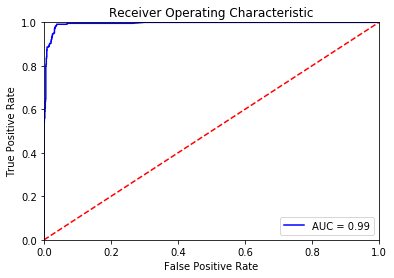

In [40]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()